In [15]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from plotting_functions import *

# Set seed
torch.manual_seed(0)

In [16]:
# Features that require StandardScaler (price-dependent and volume-based)
standard_features = ['EMA_5', 'MA_5', 'Returns', 'net_add_ask_size',
       'net_add_bid_size', 'trade_ask_size', 'trade_bid_size', 'Bollinger_Upper', 'Bollinger_Lower']

# Features that require MinMaxScaler (bounded indicators)
minmax_features = ['DMP_3', 'DMN_3', 'OLL3', 'OLL5', 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'time_since_open']

# For example "market_session"
unscaled_features = ["market_session"]

features = standard_features + minmax_features + unscaled_features

sampling_rate = "2s"
prediction_column = "Target"
batch_size = 10
epochs = 20
look_back = 32

In [17]:
from preprocessing import combine_data, add_time_features

# Generate file paths dynamically
start_date = pd.to_datetime("2024-10-03")
end_date = pd.to_datetime("2024-10-03")
date_range = pd.bdate_range(start=start_date, end=end_date)

data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

data_hft = combine_data(data_paths, sampling_rate)
data_hft = add_time_features(data_hft)

print(data_hft.columns)

data_hft.head()

Index(['mid_price_high', 'mid_price_low', 'mid_price_close', 'mid_price_open',
       'Returns', 'Target', 'add_ask_size', 'add_bid_size', 'cancel_ask_size',
       'cancel_bid_size', 'trade_ask_size', 'trade_bid_size',
       'net_add_ask_size', 'net_add_bid_size', 'EMA_5', 'MA_5',
       'Bollinger_Upper', 'Bollinger_Lower', 'DMP_3', 'DMN_3', 'OLL3', 'OLL5',
       'STOCHk_7_3_3', 'STOCHd_7_3_3', 'time_since_open', 'dow_3',
       'market_session'],
      dtype='object')


,mid_price_high,mid_price_low,mid_price_close,mid_price_open,Returns,Target,add_ask_size,add_bid_size,cancel_ask_size,cancel_bid_size,...,Bollinger_Lower,DMP_3,DMN_3,OLL3,OLL5,STOCHk_7_3_3,STOCHd_7_3_3,time_since_open,dow_3,market_session
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-03 09:30:00-04:00,225.540,225.000,225.310,225.000,0.001378,1.0,14184.0,15866.0,18934.0,8320.0,...,224.770833,0.540,0.030,0.030,0.030,60.683761,37.619225,0.0,1,0
2024-10-03 09:30:02-04:00,225.445,225.195,225.340,225.305,0.000133,1.0,5076.0,3928.0,4280.0,3370.0,...,224.755598,0.540,0.000,0.335,0.335,64.912281,54.908825,2.0,1,0
2024-10-03 09:30:04-04:00,225.610,225.340,225.610,225.340,0.001198,1.0,11729.0,9698.0,6838.0,6333.0,...,224.714850,0.705,0.000,0.340,0.370,100.000000,75.198680,4.0,1,0
2024-10-03 09:30:06-04:00,225.655,225.585,225.615,225.610,0.000022,1.0,2657.0,2677.0,2522.0,2486.0,...,224.866178,0.210,0.000,0.415,0.640,94.160584,86.357622,6.0,1,0
2024-10-03 09:30:08-04:00,225.690,225.520,225.520,225.615,-0.000421,-1.0,5337.0,2005.0,2875.0,2003.0,...,225.187075,0.210,0.065,0.275,0.615,76.388889,90.183158,8.0,1,0


In [18]:
# Data splitting

train_size = int(len(data_hft) * 0.7)
val_size = int(len(data_hft) * 0.1)
test_size = len(data_hft) - train_size - val_size

train_df = data_hft.iloc[:train_size, :]
val_df = data_hft.iloc[train_size : train_size + val_size, :]
test_df = data_hft.iloc[train_size + val_size :, :]

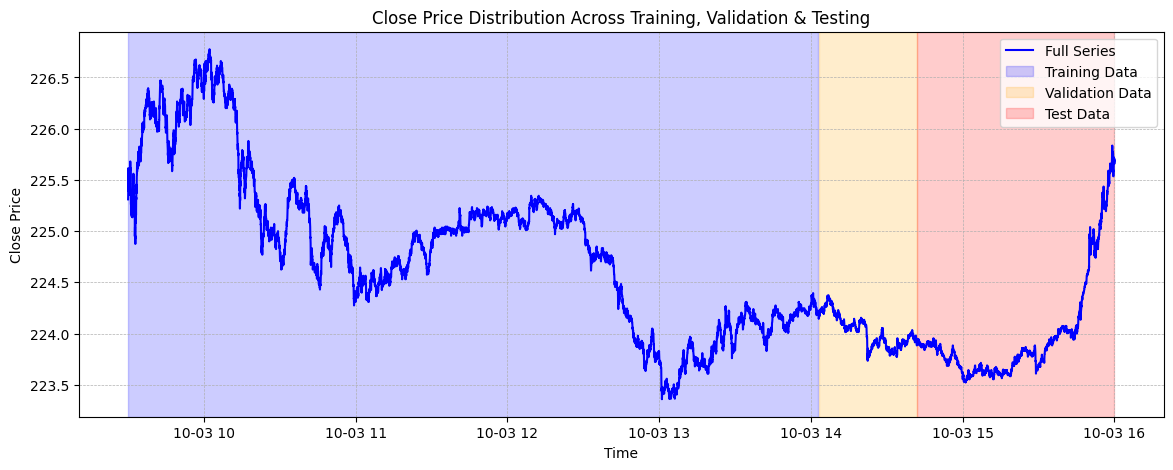

In [19]:
plot_close_price_split(data_hft, train_size, val_size)

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_indices = [train_df.columns.get_loc(col) for col in standard_features]
minmax_indices = [train_df.columns.get_loc(col) for col in minmax_features]
unscaled_indices = [train_df.columns.get_loc(col) for col in unscaled_features]

class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, look_back):
        self.data = data
        self.targets = targets
        self.look_back = look_back

    def __len__(self):
        return len(self.data) - self.look_back

    def __getitem__(self, index):
        x = self.data[index : index + self.look_back, :]
        y = self.targets[index + self.look_back]

        # Extract features using global variables
        x_standard = x[:, standard_indices]
        x_minmax = x[:, minmax_indices]
        x_unscaled = x[:, unscaled_indices]

        # Scale per-sequence (each time window separately)
        x_standard_scaled = StandardScaler().fit_transform(x_standard)  
        x_minmax_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(x_minmax)

        x_scaled = np.hstack((x_standard_scaled, x_minmax_scaled, x_unscaled))

        return torch.tensor(x_scaled, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [21]:
# Create dataset and dataloaders
train_dataset = TimeSeriesDataset(train_df.values, train_df[prediction_column].values, look_back)
val_dataset = TimeSeriesDataset(val_df.values, val_df[prediction_column].values, look_back)
test_dataset = TimeSeriesDataset(test_df.values, test_df[prediction_column].values, look_back)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

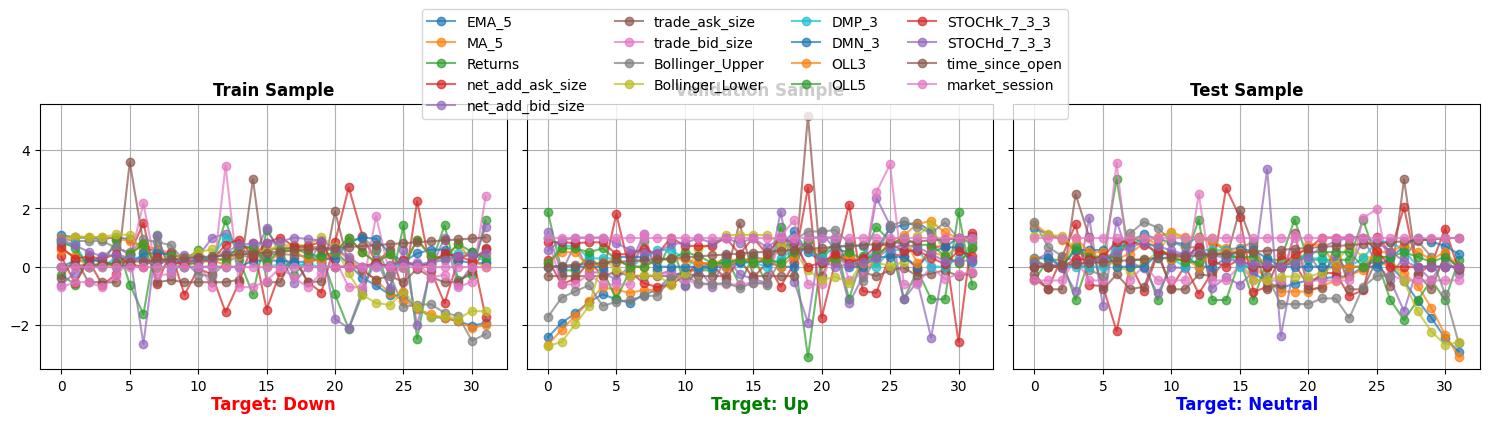

In [22]:
plot_samples([train_dataset, val_dataset, test_dataset], 
             ["Train Sample", "Validation Sample", "Test Sample"], features)


In [23]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, 3)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :] 
        lstm_out = self.batch_norm(lstm_out)
        x = self.fc(lstm_out)
        return self.softmax(x)

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size=len(features))
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [24]:
def train_model(model, train_loader, val_loader, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    total_batches = len(train_loader) * epochs
    batch_count = 0

    print("Training started...")
    start_time = time.time()

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch + 1}/{epochs} - Start time: {time.strftime('%H:%M:%S')}")
        
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
            batch_count += 1

            optimizer.zero_grad()
            outputs = model(inputs)

            targets_shifted = targets + 1

            loss = criterion(outputs, targets_shifted)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            
            correct_train += (predicted == targets_shifted).sum().item()
            total_train += targets.size(0)

            if batch_idx % 500 == 0 or batch_idx == len(train_loader) - 1:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)} (Total: {batch_count}/{total_batches}) | Time elapsed: {time.time() - epoch_start:.2f}s")

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)

                targets_shifted = targets + 1

                loss = criterion(outputs, targets_shifted)

                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)

                correct_val += (predicted == targets_shifted).sum().item()
                total_val += targets.size(0)

        val_acc = correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1} completed in {time.time() - epoch_start:.2f}s")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}\n")
    
    print(f"Training completed in {time.time() - start_time:.2f}s\n")

    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return model

# Train model
model = train_model(model, train_loader, val_loader, epochs=epochs)

Training started...
Epoch 1/20 - Start time: 17:52:08
  Batch 1/816 (Total: 1/16320) | Time elapsed: 0.09s
  Batch 501/816 (Total: 501/16320) | Time elapsed: 15.64s


KeyboardInterrupt: 

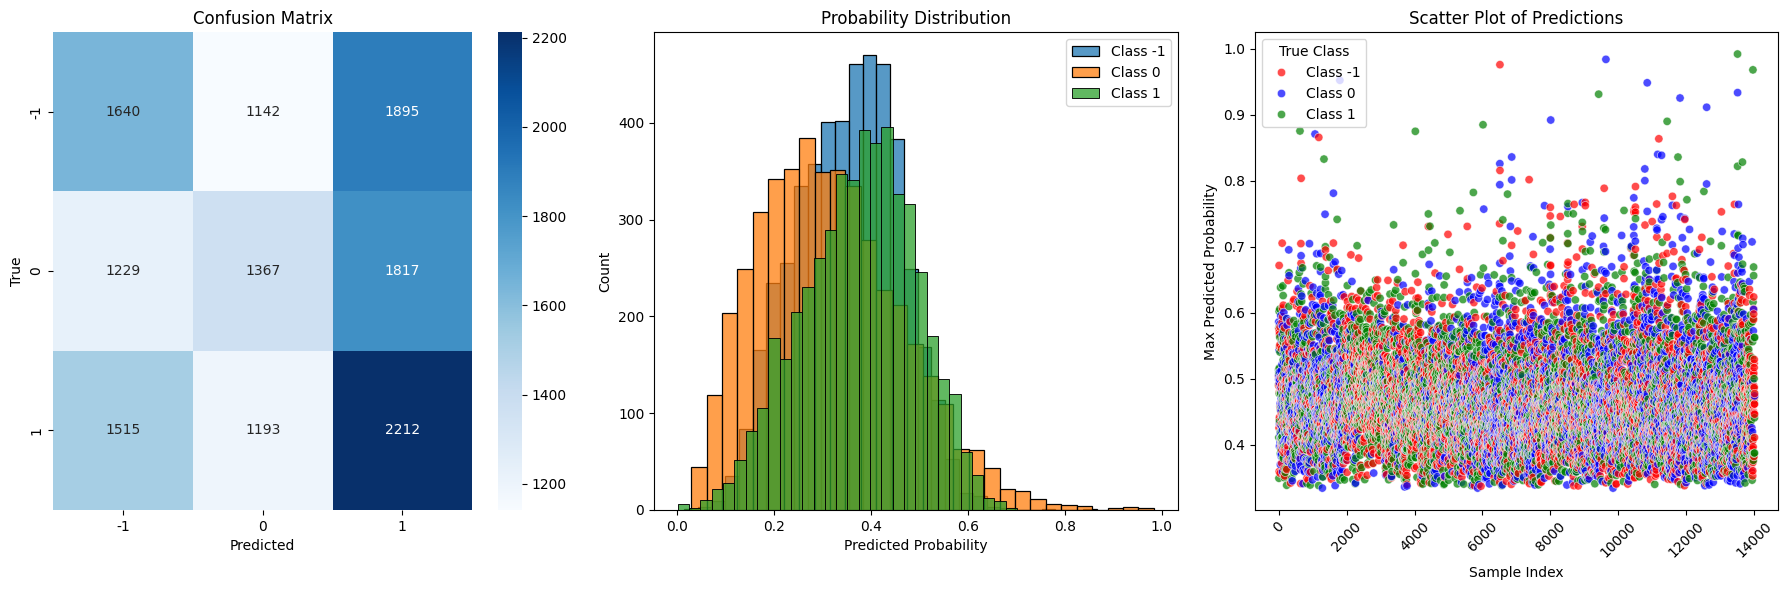

Accuracy: 0.3725
              precision    recall  f1-score   support

          -1       0.37      0.35      0.36      4677
           0       0.37      0.31      0.34      4413
           1       0.37      0.45      0.41      4920

    accuracy                           0.37     14010
   macro avg       0.37      0.37      0.37     14010
weighted avg       0.37      0.37      0.37     14010



In [ ]:
def evaluate_model(model, test_loader):
    """Evaluates the model on a test set and plots relevant metrics."""
    model.eval()
    y_true, y_pred, log_probabilities = [], [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            log_probabilities.extend(outputs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred) - 1
    log_probabilities = np.array(log_probabilities)

    plot_evaluation_metrics(y_true, y_pred, log_probabilities)

    return y_true, y_pred, log_probabilities

y_true, y_pred, log_probabilities = evaluate_model(model, test_loader)

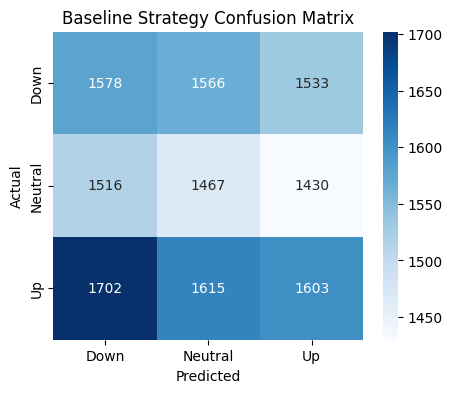

Accuracy: 0.3318
              precision    recall  f1-score   support

        -1.0       0.33      0.34      0.33      4677
         0.0       0.32      0.33      0.32      4413
         1.0       0.35      0.33      0.34      4920

    accuracy                           0.33     14010
   macro avg       0.33      0.33      0.33     14010
weighted avg       0.33      0.33      0.33     14010



In [ ]:
def baseline_strategy(df):
    """Predicts tomorrow's target as a random guess over -1, 0, 1."""
    num_samples = len(df)
    baseline_preds = np.random.choice([-1, 0, 1], size=num_samples)
    
    return baseline_preds, df["Target"]

baseline_preds, baseline_targets = baseline_strategy(test_df.iloc[look_back:, :])

# Plot baseline evaluation metrics
plot_baseline_evaluation_metrics(baseline_targets, baseline_preds)